In [ ]:
#pip install -U bertopic
#pip install -U safetensors

#!pip install scikit-learn
#!pip install hdbscan

In [17]:
from bertopic import BERTopic
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
import pandas as pd, re, unicodedata, nltk
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from bertopic import BERTopic

#load the model
topic_model = BERTopic.load("MaartenGr/BERTopic_Wikipedia")


In [31]:
test_data = pd.read_csv('dataset_germany.csv')

# Merge the text columns into a single column 'body'
test_data['body'] = test_data.apply(
    lambda row: row['post_body'] if row['type'] == 'post' else row['comment_body'],
    axis=1
)
test_data = test_data.drop(columns=['post_body', 'comment_body'])

# Drop NA and make a cleaned version
test_data_cleaned = test_data.dropna(subset=['body']).copy()

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) \
             .union(stopwords.words('german')) \
             .union(stopwords.words('french')) \
             .union(stopwords.words('italian'))
stop_words.update({
    "das", "alles", "mehr", "machen", "weiß", "sogar", "gut",
    "also", "noch", "kann", "will", "sehen", "rt", "lol", "okay", "wenn", "sein",
    "wie", "muss", "gemacht", "Leute", "wann", "auch", "das ist", "sehr"
})

# Define the preprocessor
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return " ".join([word for word in text.split() if word not in stop_words])

# Preprocess the text
test_clean = test_data_cleaned['body'].astype(str).apply(preprocess).tolist()

# Vectorizer setup
vectorizer = CountVectorizer(
    stop_words=list(stop_words),
    token_pattern=r"(?u)\b\w\w+\b",
    ngram_range=(1, 2),
    min_df=3
)

# SentenceTransformer
embedding_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# HDBSCAN clustering
hdbscan = HDBSCAN(
    min_cluster_size=50,
    min_samples=5,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

# Topic Model
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer,
    hdbscan_model=hdbscan,
    language="german",
    min_topic_size=50,
    calculate_probabilities=True,
    verbose=True 
)

# Fit the model
topics, probs = topic_model.fit_transform(test_clean)

# Add the topic results back to the cleaned DataFrame
test_data_cleaned['Topic'] = topics

# Optional: create a topic name map
topic_name_h_map = topic_model.get_topic_info().set_index('Topic')['Name'].to_dict()
test_data_cleaned['Topic_Name_H'] = test_data_cleaned['Topic'].map(topic_name_h_map)

[nltk_data] Downloading package stopwords to C:\Users\Victoria
[nltk_data]     Palchikova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-07-02 22:25:29,569 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/210 [00:00<?, ?it/s]

2025-07-02 22:29:09,711 - BERTopic - Embedding - Completed ✓
2025-07-02 22:29:09,711 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-02 22:29:12,203 - BERTopic - Dimensionality - Completed ✓
2025-07-02 22:29:12,204 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-02 22:29:13,245 - BERTopic - Cluster - Completed ✓
2025-07-02 22:29:13,250 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-02 22:29:14,006 - BERTopic - Representation - Completed ✓


In [32]:
test_data_cleaned.head


<bound method NDFrame.head of          type keyword  post_id  \
0        post   Klima  1lls9ql   
1     comment   Klima  1lls9ql   
2        post   Klima  1llnn64   
3     comment   Klima  1llnn64   
4        post   Klima  1lic6sq   
...       ...     ...      ...   
6714     post  Umwelt  1aca20x   
6715  comment  Umwelt  1abf5of   
6716  comment  Umwelt  199rlg3   
6717     post  Umwelt  197kodn   
6718  comment  Umwelt  197kodn   

                                             post_title  post_upvotes  \
0     Extremwetter-Prävention: Wie die Deutsche Bahn...          17.0   
1     Extremwetter-Prävention: Wie die Deutsche Bahn...           NaN   
2     CSU-Politiker Rainer, der „Sprechautomat des B...         573.0   
3     CSU-Politiker Rainer, der „Sprechautomat des B...           NaN   
4     Lars Klingbeil erfindet 20 Klima-Milliarden | ...        1013.0   
...                                                 ...           ...   
6714             Warum hab ich Angst vor meinen El

In [34]:
test_data_cleaned['Topic_Name_H'] = test_data_cleaned['Topic_Name_H'].str.replace(r'^\d+_', '', regex=True)

In [35]:
test_data_cleaned['Topic_Name_H'].unique().tolist()

['papa_schon_wurde_mal',
 'tiere_fleisch_ja_einfach',
 '-1_ja_co2_strom_mal',
 'klimageld_geld_ktf_ja',
 'klimawandel_klimaschutz_klima_ja',
 'energie_ja_immer_zb',
 'china_chinesen_chinesische_erneuerbaren',
 'grünen_fdp_grüne_wissing',
 'co2_luft_ccs_atmosphäre',
 'deutschland_klimaschutz_klimawandel_europa',
 'china_emissionen_indien_deutschland',
 'menschen_ja_schon_leute',
 'co2_steuer_preis_geld',
 'energie_wasser_heizung_grad',
 'mal_zeit_einfach_immer',
 'solar_solarenergie_wind_energie',
 'auto_fahren_co2_tempolimit',
 'deutschland_atomkraft_frankreich_atomstrom',
 'atomkraft_kohle_erneuerbare_erneuerbaren',
 'fliegen_co2_urlaub_flüge',
 'windenergie_wind_bayern_windkraft',
 'deutschland_strom_erneuerbaren_energiewende',
 'gw_twh_jahr_strom',
 'batterien_akku_akkus_batterie',
 'erneuerbare_erneuerbaren_energien_erneuerbare energien']

In [44]:
# Create the mapping dictionary
topic_name_map = {
    'papa_schon_wurde_mal': "random",
    'tiere_fleisch_ja_einfach': "Animals & meat consumption",
    '-1_ja_co2_strom_mal': "random",
    'klimageld_geld_ktf_ja': "Climate funding & financial support",
    'klimawandel_klimaschutz_klima_ja': "Climate change & protection",
    'energie_ja_immer_zb': "Energy usage & consumption",
    'china_chinesen_chinesische_erneuerbaren': "China & renewable energy",
    'grünen_fdp_grüne_wissing': "German Green politics & parties",
    'co2_luft_ccs_atmosphäre': "CO2 emissions",
    'deutschland_klimaschutz_klimawandel_europa': "German & European climate policy",
    'china_emissionen_indien_deutschland': "Emissions in China, India & Germany",
    'menschen_ja_schon_leute': "random",
    'co2_steuer_preis_geld': "CO2 taxation & pricing",
    'energie_wasser_heizung_grad': "Energy, water & heating",
    'mal_zeit_einfach_immer': "random",
    'solar_solarenergie_wind_energie': "Solar & wind energy",
    'auto_fahren_co2_tempolimit': "Cars, driving & CO2",
    'deutschland_atomkraft_frankreich_atomstrom': "Nuclear energy in Germany & France",
    'atomkraft_kohle_erneuerbare_erneuerbaren': "Nuclear, coal & renewable Energies",
    'fliegen_co2_urlaub_flüge': "Flying, CO2 & travel",
    'windenergie_wind_bayern_windkraft': "Wind Energy & Bavaria",
    'deutschland_strom_erneuerbaren_energiewende': "Germany's energy transition",
    'gw_twh_jahr_strom': "Electricity production & consumption",
    'batterien_akku_akkus_batterie': "Batteries & energy storage",
    'erneuerbare_erneuerbaren_energien_erneuerbare energien': "Renewable energy general"
}

# Map the 'names' column to the new human-readable topic names
test_data_cleaned['Topic_Human_Readable'] = test_data_cleaned['Topic_Name_H'].map(topic_name_map)


In [45]:
print(test_data_cleaned[['Topic_Name_H', 'Topic_Human_Readable']].head())

               Topic_Name_H        Topic_Human_Readable
0      papa_schon_wurde_mal                      random
1      papa_schon_wurde_mal                      random
2      papa_schon_wurde_mal                      random
3  tiere_fleisch_ja_einfach  Animals & meat consumption
4      papa_schon_wurde_mal                      random


In [46]:
test_data_cleaned.rename(columns={'Topic_Name_H': 'Topic_Name'}, inplace=True)

In [47]:
test_data_filtered = test_data_cleaned[test_data_cleaned['Topic_Human_Readable'] != "random"].copy()

In [54]:
print(test_data_filtered[['Topic_Name', 'Topic_Human_Readable']].head(20))



                                 Topic_Name  \
3                  tiere_fleisch_ja_einfach   
8                     klimageld_geld_ktf_ja   
11                    klimageld_geld_ktf_ja   
12         klimawandel_klimaschutz_klima_ja   
13                    klimageld_geld_ktf_ja   
14                      energie_ja_immer_zb   
15                      energie_ja_immer_zb   
16                      energie_ja_immer_zb   
17  china_chinesen_chinesische_erneuerbaren   
18                 grünen_fdp_grüne_wissing   
19  china_chinesen_chinesische_erneuerbaren   
20                  co2_luft_ccs_atmosphäre   
22         klimawandel_klimaschutz_klima_ja   
23         klimawandel_klimaschutz_klima_ja   
24         klimawandel_klimaschutz_klima_ja   
25         klimawandel_klimaschutz_klima_ja   
26         klimawandel_klimaschutz_klima_ja   
27         klimawandel_klimaschutz_klima_ja   
28         klimawandel_klimaschutz_klima_ja   
29         klimawandel_klimaschutz_klima_ja   

            

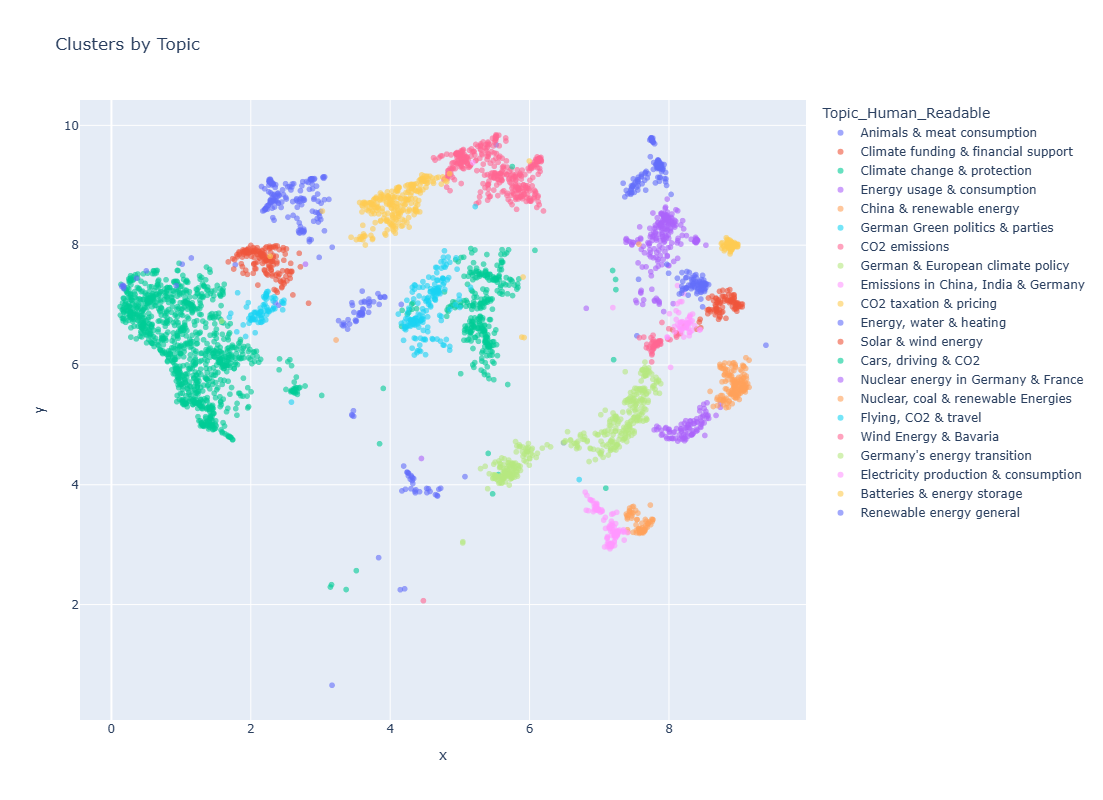

In [61]:
import plotly.express as px
import pandas as pd

import plotly.express as px

fig = px.scatter(
    test_data_filtered,
    x="x",
    y="y",
    color="Topic_Human_Readable",
    title="Clusters by Topic",
    opacity=0.6,
    height=800
)

fig.show()

In [62]:
fig.write_html("document_clusters.html")

In [66]:
test_data_filtered.head

<bound method NDFrame.head of          type    keyword  post_id  \
3     comment      Klima  1llnn64   
8     comment      Klima  1l9o0l4   
11    comment      Klima  1l31yt7   
12    comment  Erwärmung  1l31yt7   
13    comment      Klima  1l31yt7   
...       ...        ...      ...   
6704  comment     Umwelt  1bcskll   
6705  comment     Umwelt  1bcskll   
6706  comment     Umwelt  1bcskll   
6708  comment     Umwelt  1bc2y3a   
6716  comment     Umwelt  199rlg3   

                                             post_title  post_upvotes  \
3     CSU-Politiker Rainer, der „Sprechautomat des B...           NaN   
8     Angst vorm Klima: Finanzfirmen machen grüne Ro...           NaN   
11    Klima-Milliarden für Gas-Pipelines? | Das neue...           NaN   
12    Klima-Milliarden für Gas-Pipelines? | Das neue...           NaN   
13    Klima-Milliarden für Gas-Pipelines? | Das neue...           NaN   
...                                                 ...           ...   
6704  Glyphosa

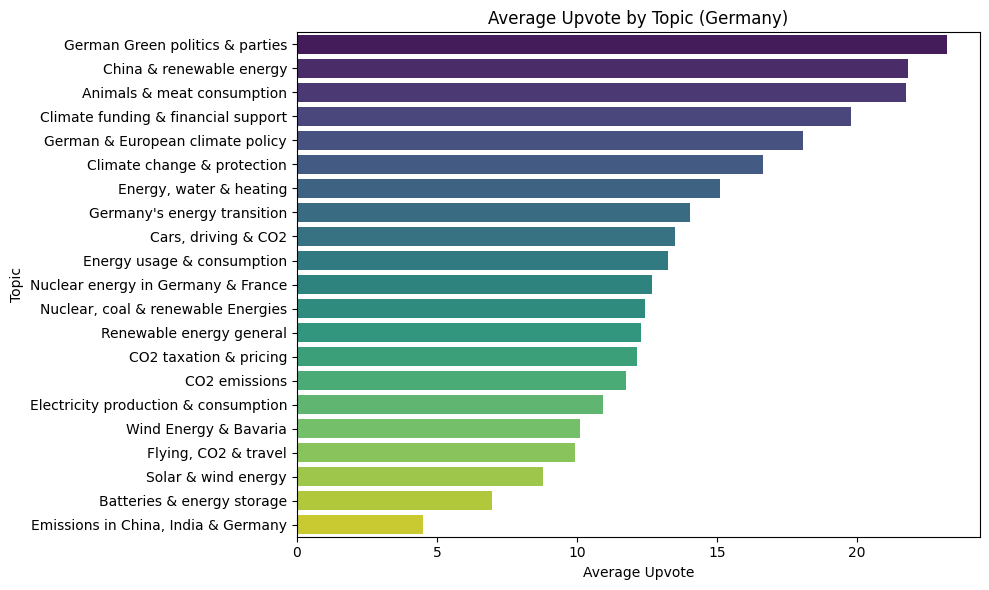

In [71]:
# Group by 'topic' and calculate average score
avg_scores = test_data_filtered.groupby('Topic_Human_Readable')['comment_upvotes'].mean().reset_index()

# Sort by average score (optional, for better visualization)
avg_scores = avg_scores.sort_values(by='comment_upvotes', ascending=False)

# Create a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='comment_upvotes', y='Topic_Human_Readable', data=avg_scores, palette='viridis')
plt.title('Average Upvote by Topic (Germany)')
plt.xlabel('Average Upvote')
plt.ylabel('Topic')
plt.tight_layout()
plt.show()

In [72]:
from meteostat import Daily, Stations
from datetime import datetime
import pandas as pd

# Define time period
start = datetime(2024, 1, 1)
end = datetime(2025, 1, 1)

# Find weather stations for Paris, Berlin, Rome
stations = Stations()

paris = stations.nearby(48.8566, 2.3522).fetch(1)
berlin = stations.nearby(52.5200, 13.4050).fetch(1)
rome = stations.nearby(41.9028, 12.4964).fetch(1)

# Get daily data for each city
data_paris = Daily(paris.index[0], start, end).fetch()
data_berlin = Daily(berlin.index[0], start, end).fetch()
data_rome = Daily(rome.index[0], start, end).fetch()

# Add a column for city/country
data_paris['city'] = 'Paris'
data_paris['country'] = 'France'

data_berlin['city'] = 'Berlin'
data_berlin['country'] = 'Germany'

data_rome['city'] = 'Rome'
data_rome['country'] = 'Italy'

# Combine all dataframes into one
combined_data = pd.concat([data_paris, data_berlin, data_rome])

# Reset index to have date as a column
combined_data = combined_data.reset_index()

print(combined_data.head())

        time  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun  \
0 2024-01-01   8.2   6.2  10.9   4.1  <NA>  <NA>  16.4  <NA>  1009.3  <NA>   
1 2024-01-02  10.9   9.9  11.8  <NA>  <NA>  <NA>  28.0  <NA>   998.6  <NA>   
2 2024-01-03  10.8   9.1  12.7  <NA>  <NA>  <NA>  20.2  <NA>   999.8  <NA>   
3 2024-01-04   9.6   7.6  11.1  <NA>  <NA>  <NA>  16.4  <NA>  1006.2  <NA>   
4 2024-01-05   7.9   6.1   9.9  <NA>  <NA>  <NA>  12.2  <NA>  1004.3  <NA>   

    city country  
0  Paris  France  
1  Paris  France  
2  Paris  France  
3  Paris  France  
4  Paris  France  


In [95]:
test_data_filtered['date'] = pd.to_datetime(test_data_filtered['comment_created_utc'], unit='s', utc=True)
print(test_data_filtered)

         type    keyword  post_id  \
3     comment      Klima  1llnn64   
8     comment      Klima  1l9o0l4   
11    comment      Klima  1l31yt7   
12    comment  Erwärmung  1l31yt7   
13    comment      Klima  1l31yt7   
...       ...        ...      ...   
6704  comment     Umwelt  1bcskll   
6705  comment     Umwelt  1bcskll   
6706  comment     Umwelt  1bcskll   
6708  comment     Umwelt  1bc2y3a   
6716  comment     Umwelt  199rlg3   

                                             post_title  post_upvotes  \
3     CSU-Politiker Rainer, der „Sprechautomat des B...           NaN   
8     Angst vorm Klima: Finanzfirmen machen grüne Ro...           NaN   
11    Klima-Milliarden für Gas-Pipelines? | Das neue...           NaN   
12    Klima-Milliarden für Gas-Pipelines? | Das neue...           NaN   
13    Klima-Milliarden für Gas-Pipelines? | Das neue...           NaN   
...                                                 ...           ...   
6704  Glyphosat entsteht womöglich aus Wasch

In [87]:
# Define temperature thresholds (you can adjust these)
hot_threshold = combined_data['tavg'].quantile(0.75)   # top 25% hottest days
cold_threshold = combined_data['tavg'].quantile(0.25)  # bottom 25% coldest days

# Create a temperature category column
def temp_category(temp):
    if temp >= hot_threshold:
        return 'Hot'
    elif temp <= cold_threshold:
        return 'Cold'
    else:
        return 'Moderate'

combined_data['temp_category'] = combined_data['tavg'].apply(temp_category)



In [88]:
print(combined_data['temp_category'].value_counts())

temp_category
Moderate    540
Cold        275
Hot         275
Name: count, dtype: int64


In [90]:
hot_days = combined_data[combined_data['temp_category'] == "Hot"]
print(hot_days)

           time  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun  \
103  2024-04-13  19.5  12.7  26.3   0.0  <NA>  <NA>   9.7  <NA>  1026.3  <NA>   
130  2024-05-10  19.0  12.3  25.1   0.0  <NA>  <NA>  10.5  <NA>  1021.6  <NA>   
131  2024-05-11  20.7  13.6  27.0   0.0  <NA>  <NA>   8.6  <NA>  1017.8  <NA>   
132  2024-05-12  19.9  15.5  26.3   1.0  <NA>  <NA>   6.5  <NA>  1013.6  <NA>   
155  2024-06-04  19.4  14.5  24.4   0.3  <NA>  <NA>   8.9  <NA>  1014.6  <NA>   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...     ...   ...   
1017 2024-10-17  20.3  16.0  25.0   1.5  <NA>  <NA>  10.0  <NA>  1019.2  <NA>   
1018 2024-10-18  20.3  17.1  24.0  24.5  <NA>  <NA>  12.8  <NA>  1016.3  <NA>   
1021 2024-10-21  19.3  14.3  27.0   0.0  <NA>  <NA>   6.8  <NA>  1025.4  <NA>   
1022 2024-10-22  20.2  16.4  26.0   7.7  <NA>  <NA>   6.9  <NA>  1026.3  <NA>   
1024 2024-10-24  19.2  16.8  24.0  16.8  <NA>  <NA>   6.3  <NA>  1026.8  <NA>   

       city country temp_ca

In [99]:
test_data_filtered['comment_date'] = pd.to_datetime(test_data_filtered['comment_created_utc'], unit='s').dt.date
print(test_data_filtered['comment_date'])

3       2025-06-27
8       2025-06-12
11      2025-06-04
12      2025-06-04
13      2025-06-04
           ...    
6704    2024-03-12
6705    2024-03-12
6706    2024-03-12
6708    2024-03-11
6716    2024-01-18
Name: comment_date, Length: 4157, dtype: object


In [100]:
combined_data['date_only'] = pd.to_datetime(combined_data['time']).dt.date

In [103]:
germany_hot_days = hot_days[hot_days['country'] == 'Germany']


In [105]:
germany_hot_days.head

<bound method NDFrame.head of           time  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres   tsun  \
465 2024-04-08  19.4  13.8  26.6  <NA>  <NA>  <NA>   9.0  25.9  1010.9  470.0   
487 2024-04-30  19.7  11.6  27.6  <NA>  <NA>  <NA>  16.0  38.9  1018.0  709.0   
488 2024-05-01  20.8  14.2  26.6  <NA>  <NA>  <NA>  20.2  50.0  1011.4  703.0   
489 2024-05-02  20.6  14.6  26.0  <NA>  <NA>  <NA>  20.1  48.2  1005.2  625.0   
502 2024-05-15  20.1  13.1  26.3  <NA>  <NA>  <NA>  20.8  50.0  1012.0  829.0   
..         ...   ...   ...   ...   ...   ...   ...   ...   ...     ...    ...   
615 2024-09-05  24.7  18.9  31.1  <NA>  <NA>  <NA>  19.9  51.8  1014.7  711.0   
616 2024-09-06  23.2  17.8  29.2  <NA>  <NA>  <NA>  17.0  40.8  1015.0  677.0   
617 2024-09-07  23.1  16.0  30.1  <NA>  <NA>  <NA>  13.0  31.5  1013.8  640.0   
618 2024-09-08  24.5  18.8  31.2  <NA>  <NA>  <NA>  12.8  27.8  1009.0  616.0   
628 2024-09-18  19.2  13.8  25.3  <NA>  <NA>  <NA>  13.7  31.5  1028.3  636.0  

In [127]:
germany_hot_days_dates = germany_hot_days.date

In [131]:
topics_hot_days = test_data_filtered[test_data_filtered['comment_date'].isin(germany_hot_days_dates)]

In [132]:
print(topics_hot_days)

         type     keyword  post_id  \
654   comment         CO2  1fk0nmc   
656   comment       Klima  1fk0nmc   
660   comment       Klima  1fk0nmc   
661   comment       Klima  1fk0nmc   
663   comment       Klima  1fk0nmc   
...       ...         ...      ...   
6640  comment  Hitzewelle  1cxapy7   
6648  comment      Umwelt  1crmlmu   
6653  comment      Umwelt  1crmlmu   
6658  comment      Umwelt  1crmlmu   
6661  comment      Umwelt  1crmlmu   

                                             post_title  post_upvotes  \
654   Klimapolitik: Großes Schweigen | Österreich, O...           NaN   
656   Klimapolitik: Großes Schweigen | Österreich, O...           NaN   
660   Klimapolitik: Großes Schweigen | Österreich, O...           NaN   
661   Klimapolitik: Großes Schweigen | Österreich, O...           NaN   
663   Klimapolitik: Großes Schweigen | Österreich, O...           NaN   
...                                                 ...           ...   
6640  Mexiko: Brüllaffen fallen 

In [133]:
upvotes_by_topic = topics_hot_days.groupby('Topic_Human_Readable')['comment_upvotes'].sum().reset_index()

In [137]:
#pip install --upgrade kaleido

     ---------------------------------------- 0.0/43.0 kB ? eta -:--:--
     ---------------------------------------- 43.0/43.0 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/51.5 kB ? eta -:--:--
   ---------------------------------------- 51.5/51.5 kB 2.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/51.3 kB ? eta -:--:--
   ---------------------------------------- 51.3/51.3 kB ? eta 0:00:00
   ---------------------------------------- 0.0/134.8 kB ? eta -:--:--
   ---------------------------------------- 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/75.7 kB ? eta -:--:--
   ---------------------------------------- 75.7/75.7 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


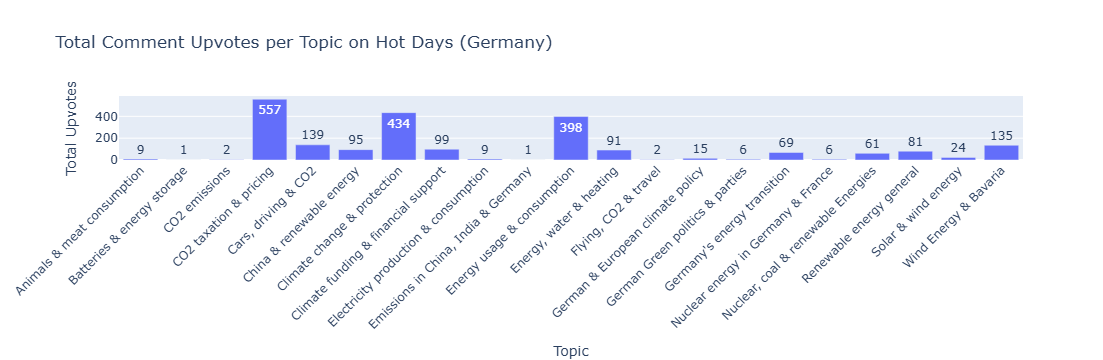

ValueError: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido


In [138]:
import plotly.express as px

fig = px.bar(
    upvotes_by_topic,
    x='Topic_Human_Readable',
    y='comment_upvotes',
    title='Total Comment Upvotes per Topic on Hot Days (Germany)',
    labels={'Topic_Human_Readable': 'Topic', 'comment_upvotes': 'Total Upvotes'},
    text='comment_upvotes'
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

fig.write_image("filename.png")